In [24]:
"""
Here are all definitions, this must be initiated before any other cell can be run.

Gaskell Eros Shape Model V1.0 data set, ID: NEAR-A-MSI-5-EROSSHAPE-V1.0. 
"""
%matplotlib notebook
from points import *
from LS import *
from scipy.interpolate import UnivariateSpline as interpolator, interpn, interp1d
# Plotting definitions

from matplotlib import rc
rc('text', usetex=True)
plt.style.use('ggplot')
#plt.rcParams['font.family'] = 'Lucida Grande'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.style.use('dark_background')

# Function definitions
def interp(φ, Γ, ib, il):
    φn = np.linspace(0, 2*π, 200)
    vals = Γ[:, ib, il, :]
    Γip = np.zeros([φn.size, 3])

    for i in range(3):
        spl = interpolator(φ, vals[:,i])
        spl.set_smoothing_factor(0.5)
        Γip[:,i] = spl(φn)
    return φn, Γip

# Calculations are done as follows: Probe the angles determining the direction of the 
# body axis (in red). Latitude β measured as the angle between body axis and 
# illumination (in black), given by positive rotation of β in (0,π) about the x-axis. 
# Angle λ in (0,2π) corresponds to rotation about the y-axis. All in all we
# use the YX'Z''- intrinsic rotation notation, where we initially rotate λ about z-axis,
# then β about the new x-axis and finally rotate the body about the final z-axis

λ = np.linspace(0, π, 50)
β = np.linspace(0, 2*π, 50)
φ = np.linspace(0, 2*π, 50)

In [7]:
"""
Here we choose which level of detail (don't worry, everything is precalculated) to use. 
This way, it is easier to compare how convergence should work here.
"""

detail_levels = ['low', 'normal', 'high']

level = 2

mesh = pymesh.load_mesh('eros_{:s}_detail.mesh'.format(detail_levels[level]))
P = mesh.nodes; T = mesh.elements
I = trimesh.Trimesh(vertices=P, faces=T, process=False).moment_inertia
Ip, Q = trimesh.inertia.principal_axis(I)
P = matmul(P,Q.T)
T, N, C = surface_normals(P, T)
mesh = pymesh.form_mesh(P,T)


In [9]:
"""
Compute the radiative torque in scattering frame (SF) and derive the qmax value.
The scattering coordinates are Θ between a_1 and k, Φ = 0 about k and β about R(Θ)a_1.
The precalculated torque system (λ = 0,β,φ) corresponds to (Φ_SF = 0, -Θ_SF, β_SF) in SF. 
I know, confusing, innit...
"""
data = np.loadtxt('data-{:s}.dat'.format(detail_levels[level]))
Γ = data.reshape([φ.size, β.size, λ.size, 3])

Φ_SF = 0
Θ_SF = np.linspace(0, π, 50)
β_SF = np.linspace(0, 2*π, 50)

Q = np.zeros([Θ_SF.size,3])
for i, th in enumerate(Θ_SF):
    for j, b in enumerate(β_SF):
        Q[i,:] += interpn([φ,β,λ], Γ[:,:,:,:], np.array([b, 2*π-th, Φ_SF]))[0]

qmax = 0.047


<IPython.core.display.Javascript object>


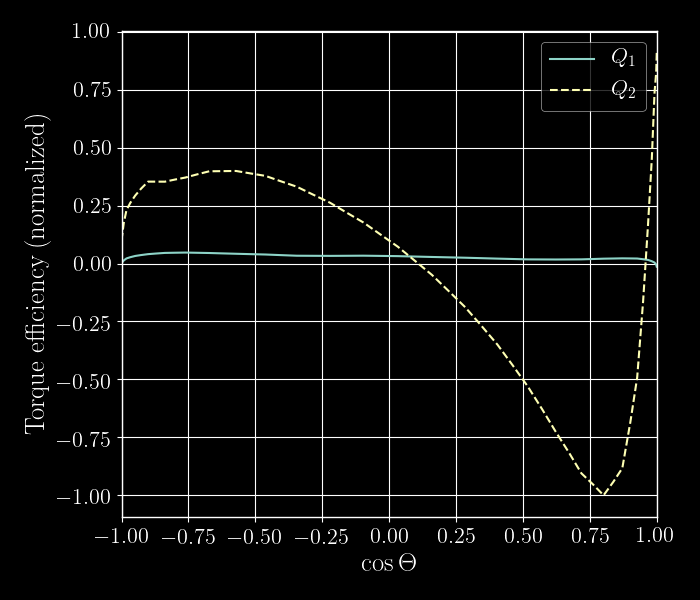

In [14]:
q_max = np.amax(np.abs(Q[:,2]))/np.amax(np.abs(Q[:,1]))
scale = np.amax([np.amax(np.abs(Q[:,1])),np.amax(np.abs(Q[:,2]))])
print('qmax = {:.3f}'.format(q_max))

x = cos(Θ_SF)

fig = plt.figure(figsize=(7,6))

plt.plot(x, Q[:,2]/scale, label=r'$Q_1$')
plt.plot(x, Q[:,1]/scale, '--', label=r'$Q_2$')
#plt.plot(x, Q[:,0]/scale, ':', label='Q_3')

plt.xlim([-1, 1])
plt.legend()

plt.xlabel(r'$\cos \Theta$')
plt.ylabel('Torque efficiency (normalized)')
plt.tight_layout()

plt.savefig('RAT-{:s}.png'.format(detail_levels[level]))

In [50]:
"""
RAT analogue calculations in alignment frame
"""
def Q_to_FHG(Q1, Q2, costheta, psi, xi, phi):
    cth = cos(xi)*cos(psi)-sin(xi)*sin(psi)*cos(phi)
    th = arccos(cth)
    psi_b = 2.*np.arctan2(sin(th)-sin(xi)*sin(psi),sin(xi)*sin(phi))
    f1 = interp1d(costheta, Q1)
    f2 = interp1d(costheta, Q2)
    Q_t = [f1(cth), f2(cth), 0.]
    
    F = Q_t[0]*(-sin(psi)*cos(xi)*cos(phi)-cos(psi)*sin(xi)) \
        + Q_t[1]*(cos(psi_b)*(cos(psi)*cos(xi)*cos(phi)-sin(psi)*sin(xi)) \
        + sin(psi_b)*cos(xi)*sin(phi)) \
        + Q_t[2]*(cos(psi_b)*cos(xi)*sin(phi)+sin(psi_b)*(sin(psi)*sin(xi)-cos(psi)*cos(xi)*cos(phi)))
    
    H = Q_t[0]*(-sin(psi)*sin(xi)*cos(phi)+cos(psi)*cos(xi)) \
        + Q_t[1]*(cos(psi_b)*(sin(psi)*cos(xi)+cos(psi)*sin(xi)*cos(phi))+sin(psi_b)*sin(xi)*sin(phi))

    G = Q_t[0]*(sin(psi)*sin(phi)) \
        + Q_t[1]*(sin(psi_b)*cos(phi)-cos(psi_b)*cos(psi)*sin(phi)) \
        + Q_t[2]*(cos(psi_b)*cos(phi)-sin(psi_b)*cos(psi)*sin(phi))
    return np.array([F, H, G])
data = np.loadtxt('data-{:s}.dat'.format(detail_levels[level]))

# Alignment coordinates
ξ = np.linspace(0, π, 100)
φ = np.linspace(0, 2*π, 100)
ψ = 0

import time, datetime
F = np.zeros([ξ.size])
H = np.zeros([ξ.size])
G = np.zeros([ξ.size])

start = time.time()
for i, xi in enumerate(ξ):
    for j, fj in enumerate(φ):
        FHG = Q_to_FHG(Q[:,2], Q[:,1], x, ψ, xi, fj)/φ.size/scale
        F[i] += FHG[0]
        H[i] += FHG[1]
        G[i] += FHG[2]
end = time.time()
print('Done in', str(datetime.timedelta(seconds=np.round(end-start,0))))


Done in 0:00:02


In [57]:
gradF = np.gradient(F, (ξ[1]-ξ[0]))
n_attr = 0; deltam = 0.1
# Test universal stationary points sin xi = 0
if np.abs(H[0])>1e-12:
    if gradF[0]/H[0]<0.:
        n_attr = n_attr + 1
elif np.abs(H[-1])>1e-12:
    if gradF[-1]/H[-1]<0.:
        n_attr = n_attr + 1
print('Attractor exists: {}'.format(bool(n_attr)))

täällä
Attractor exists: True


<IPython.core.display.Javascript object>


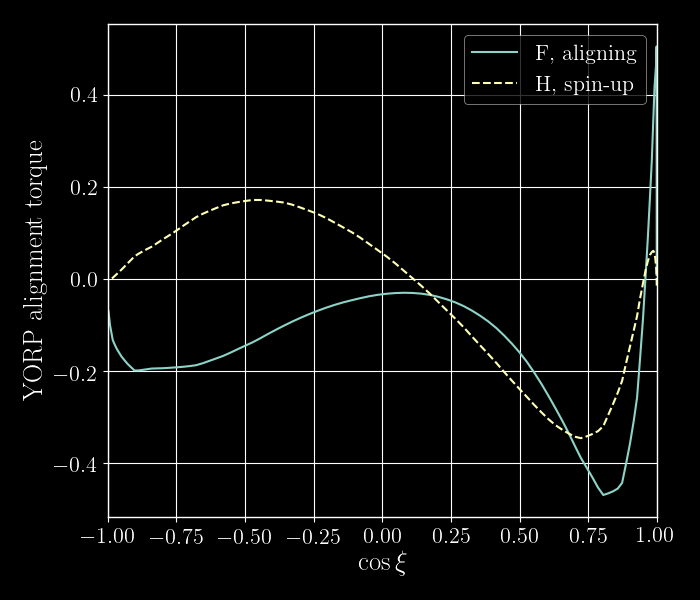

In [53]:
fig = plt.figure(figsize=(7,6))
plt.plot(cos(ξ),F,label='F, aligning')
plt.plot(cos(ξ),H,'--',label='H, spin-up')
#plt.plot(ξ/π,G,':',label='G')
plt.xlabel(r'$\cos\xi$')
plt.ylabel('YORP alignment torque')
plt.xlim([-1,1])
plt.legend()
plt.tight_layout()
plt.savefig('FHG.png')